In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import binom, norm
from statsmodels.stats.proportion import proportion_confint, proportions_ztest, samplesize_confint_proportion

# Confidence Intervals for Proportions

**Correct Interpretation**

Ex: 95% confidence intervval estimate of population proportion being (0.5, 0.6).

Interpreation: If we select many random samples, of the same sample size, and construct confidence intervals for them all.
95% of the confidence intervals will contain the population proportion.
If we repeat this process over and over, we should end up creating many confidence intervals and a "confidence level" proportion of them will contain the true population proportion.

Bad interpreation: There is a 95% chance the true population proportion will fall in the range of the confidence interval.

**Margin of Error**

Note: this is for Wald confidence intervals.

When a single random sample is used to estimate a population proportion, you can calculate the maximum likely amount of the error as such

$$
E = z_{\alpha / 2} \sqrt{ \frac{\hat p \hat q}{n} }
$$

Here $z_{\alpha / 2}$ is the critical value for the given confidence level $\alpha$.
The margin of error is the probability of $1 - \alpha$ (i.e., 95%) that the difference between the sample proportion and the population proportion is equal to or less than the margin of error.

This formula is one of the ways to build a confidence interval.

## Coverage Probability

The coverage probability of a confidence interval is the proportion in which our confidence intevals actually contain the population proportion.
The margin of error expression we offer above is for a Wald confidence interval whose coverage probability is equal to or less than the desired confidence interval.

* Plus Four Method is better than Wald and it just adds 2 successes and 2 failures to the sample size.
* Wilson Score is also better than Wald but the margin of error formula is more complicated (and more complex to invert to estimate sample sizes).
* Clopper-Pearson Method is exact because it makes use of a binomial distribution instead of using the normal distribution as an approximation. **Stats Model does support this method, set "method=beta"**.

## Approximating a Binomial Distribution with a Normal One

$$
\mu = np
$$

$$
\sigma = \sqrt{npq}
$$

Make sure that $np \geq 5$ and $nq \geq 5$ (or greater than 10).

## References

* Statsmodel index https://www.statsmodels.org/dev/stats.html
* Confidence interval for binomial proportions https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
* Find sample size to get desired confidence interval length https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.samplesize_confint_proportion.html

In [3]:
def proportion_margin_of_error(sample_proportion, sample_size, confidence_lvl=0.95) -> float:
    """ Wald confidence interval
    """
    alpha = 1 - confidence_lvl
    critical_value = norm.ppf(confidence_lvl + (alpha / 2.0)) # We want the Z score from the desired covered area.
    
    q = 1.0 - sample_proportion
    return critical_value * np.sqrt(sample_proportion * q / sample_size)

def binom_estimated_mu(p, n) -> float:
    return n*p

def binom_estimated_sigma(p, n) -> float:
    return np.sqrt(n * p * (1.0-p))

In [4]:
# A gallup poll showed 43% of adults used facebook. Sample size was 1_487.

margin_err = proportion_margin_of_error(0.43, 1_487, confidence_lvl=0.95)

ci_low, ci_high = proportion_confint(
    count=0.43 * 1_487,  # Number of "successes"
    nobs=1_487,  # Number of trials.
    alpha=(1 - 0.95))

print(f"margin of error = {round(margin_err, 3)}")
print(f"CI low and CI high with estimated margin of error: ({round(0.43 - margin_err, 3)}, {round(0.43 + margin_err, 3)})")
print(f"CI low and CI high from statsmodel: ({round(ci_low, 3)}, {round(ci_high, 3)})")

margin of error = 0.025
CI low and CI high with estimated margin of error: (0.405, 0.455)
CI low and CI high from statsmodel: (0.405, 0.455)


In [5]:
# This works because here we can use a normal distribution to approximate the binomial distribution.
norm.interval(0.95, loc=binom_estimated_mu(0.43, 1_487), scale=binom_estimated_sigma(0.43, 1_487))

(601.9924600596482, 676.8275399403517)

In [6]:
binom.interval(0.95, n=1_487, p=0.43)

(602.0, 677.0)

In [7]:
# Both of the above give the number of successes, not the proportion.
print(f"({round(602/1_487, 3)}, {round(677/1_487, 3)})")

(0.405, 0.455)


In [8]:
# Out of 71 people, 70% were abstinent from smoking after 8 weeks of nicotine patches.
# 95% confidence interval 58% to 81%.

ci_low, ci_high = proportion_confint(
    count=50, #0.7 * 71 - Number of "successes"
    nobs=71,  # Number of trials.
    alpha=(1 - 0.95))

ci_low_exact, ci_high_exact = proportion_confint(
    count=50, #0.7 * 71 - Number of "successes"
    nobs=71,  # Number of trials.
    method="beta",
    alpha=(1 - 0.95))

estimate_margin_err = (ci_high - ci_low) / 2.0
estimate_population_p = (ci_high + ci_low) / 2.0

estimate_margin_err_exact = (ci_high_exact - ci_low_exact) / 2.0
estimate_population_p_exact = (ci_high_exact + ci_low_exact) / 2.0

print(f"CI low and CI high from statsmodel: ({round(ci_low, 3)}, {round(ci_high, 3)})")
print(f"margin of error: {round(estimate_margin_err, 3)}")
print(f"estimate of population proportion: {round(estimate_population_p, 3)}")

print(f"CI low and CI high from statsmodel using Clopper-Pearson: ({round(ci_low_exact, 3)}, {round(ci_high_exact, 3)})")
print(f"margin of error using Clopper Pearson: {round(estimate_margin_err_exact, 3)}")
print(f"estimate of population proportion using Clopper-Pearson: {round(estimate_population_p_exact, 3)}")

CI low and CI high from statsmodel: (0.598, 0.81)
margin of error: 0.106
estimate of population proportion: 0.704
CI low and CI high from statsmodel using Clopper-Pearson: (0.584, 0.807)
margin of error using Clopper Pearson: 0.111
estimate of population proportion using Clopper-Pearson: 0.695


## Determining Sample Size

In [9]:
def estimate_ci_sample_size(margin_of_error, proportion=0.5, confidence_lvl=0.95) -> int:
    """ Based on Wald confidence interval
    """
    alpha = 1 - confidence_lvl
    critical_value = norm.ppf(confidence_lvl + (alpha / 2.0)) # We want the Z score from the desired covered area.
    
    q = 1 - proportion
    return critical_value**2 * proportion * q / (margin_of_error**2)

In [10]:
# How many people to build a CI with 95% confidence and have an error of no more than 3 percentage points.
estimate_sample_size = estimate_ci_sample_size(
    margin_of_error=0.03,
    proportion=0.5,  # 0.5 maximizes the value.
    confidence_lvl=0.95)

estimate_n = samplesize_confint_proportion(proportion=0.5, half_length=0.03, alpha=(1-0.95))

print(f"estimated sample size based on margin of error: {estimate_sample_size}")
print(f"estimate sample size from statsmodel: {estimate_n}")

estimated sample size based on margin of error: 1067.0718946372572
estimate sample size from statsmodel: 1067.0718946372572


# Confidence Intervals for Means

Simplest way to build a CI for estimating a population mean is using a t distribution

$$
E = t_{\alpha / 2} \frac{s}{\sqrt{n}}
$$

Where $E$ is again the margin of error and $s$ is the standard derivation from the sample (best estimate we got).
Which is not a bad approximation if population is normally distributed or $n>30$.

* t distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
* stats model doesn't seem to have a method for this specific CI

In [11]:
from scipy.stats import t

In [12]:
def mean_margin_of_error(sample_std, sample_size, confidence_lvl=0.95) -> float:
    df = sample_size - 1
    alpha = 1 - confidence_lvl
    critical_value = t.ppf(confidence_lvl + (alpha / 2.0), df=df) # We want the t score from the desired covered area.
    
    print(f"using critical value of {critical_value}")
    return critical_value * (sample_std / np.sqrt(sample_size))

In [13]:
birth_weigths = np.array([33, 28, 33, 37, 31, 32, 31, 28, 34, 28, 33, 26, 29, 31, 30])

In [14]:
birth_weigths.mean() # Ans: 30.9.

30.933333333333334

In [15]:
birth_weigths.std(ddof=1) # Ans: 2.9. ddof=1 because this is a sample.

2.865226659362887

In [16]:
birth_weigths.size

15

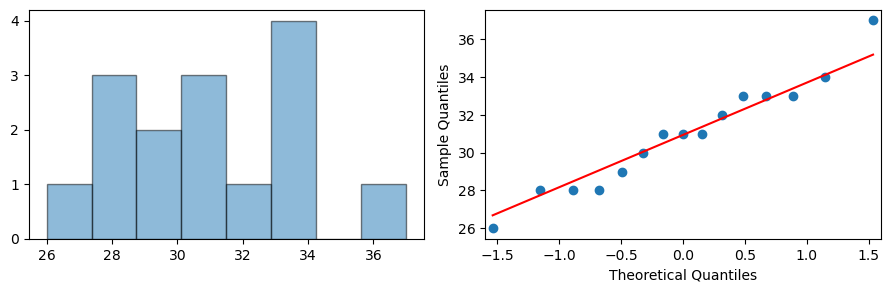

In [17]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(121)
ax1.hist(birth_weigths, bins=8, edgecolor="black", alpha=0.5)

ax2 = fig.add_subplot(122)
sm.qqplot(birth_weigths, ax=ax2, line='s')

fig.tight_layout(pad=1.0)
plt.show()

In [18]:
sample_mean = birth_weigths.mean()

margin_err = mean_margin_of_error(
    birth_weigths.std(ddof=1), birth_weigths.size,
    confidence_lvl=0.95)

print(f"margin of error = {round(margin_err, 3)}")
print(f"CI low and CI high with estimated margin of error: ({round(sample_mean - margin_err, 3)}, {round(sample_mean + margin_err, 3)})")

using critical value of 2.1447866879169273
margin of error = 1.587
CI low and CI high with estimated margin of error: (29.347, 32.52)


In [19]:
# The above stimate is very much off.
# Compare it with a more trusted way of getting a confidence interval.
t.interval(0.95, df=birth_weigths.size-1, loc=birth_weigths.mean(), scale=birth_weigths.std(ddof=1))

(24.788033336467127, 37.078633330199544)

In [20]:
norm.interval(0.95, loc=birth_weigths.mean(), scale=birth_weigths.std(ddof=1))

(25.317592273438063, 36.54907439322861)

In [21]:
# Our "simple" margin of error formula gives a very narrow CI but the point estimate agrees.
estimate_1 = round((32.520 + 29.347)/2, 3)
estimate_2 = round((37.079 + 24.788)/2, 3)
print(f"{estimate_1} {estimate_2}")

30.934 30.934


# Confidence Intervals for Standard Deviations

Normality is a much stricter requirement for this method: it doesn't matter if the sample size is large, the population must be normally distributed.
If this is not the case then we need to use bootstrapping methods.

An estimate formula for building confidence intervals to estimate a population's variance or standard deviation are the following:
$$
\frac{(n-1)s^2}{\chi^{2}_{R}} < \sigma^2 < \frac{(n-1)s^2}{\chi^{2}_{L}}
$$

$$
\sqrt{ \frac{(n-1)s^2}{\chi^{2}_{R}} } < \sigma < \sqrt{ \frac{(n-1)s^2}{\chi^{2}_{L}} }
$$

The above expression comes from the fact that chi-squared random variables are distributed as
$$
\chi^2 = \frac{(n-1) s^2}{\sigma^2}
$$

**Note:** there is a probability $1-\alpha$ that the sample statistic will fall between the critical values $\chi^{2}_{R}$ and $\chi^{2}_{L}$.

* Chi-Squared distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html

In [27]:
from typing import Tuple
from scipy.stats import chi2

In [25]:
# Critical values for a 95% confidence interval from a sample of 22 measurements.
chi2.ppf(0.05/2, df=21), chi2.isf(0.05/2, df=21) # Ans: 10.283, 35.475.

(10.28289778252286, 35.47887590572725)

In [38]:
def variance_ci(sample_variance: float, sample_size: int, confidence_level: float=0.95) -> Tuple[float, float]:
    df = sample_size - 1
    
    alpha = 1.0 - confidence_level
    chi2_l, chi2_r = chi2.ppf(alpha/2.0, df=df), chi2.isf(alpha/2.0, df=df)
    
    numerator = df * (sample_variance**2.0)
    lo_bound = numerator/chi2_r
    hi_bound = numerator/chi2_l
    return lo_bound, hi_bound

In [39]:
# Sample of 22 with standard deviation of 14.293.
ci_low, ci_high = variance_ci(sample_variance=14.29263, sample_size=22, confidence_level=0.95)

ci_low_std, ci_high_std = np.sqrt(ci_low), np.sqrt(ci_high)

print(f"variance CI: ({ci_low}, {ci_high})")
print(f"std deviation CI: ({ci_low_std}, {ci_high_std})")

variance CI: (120.91320846956145, 417.1844172122464)
std deviation CI: (10.996054222745606, 20.425092832402168)
